In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import intake 
import pprint
from src.LE_LoadAndMerge import *
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [3]:
import sys
sys.path.append('/home/jupyter/AdaptationAnalysis/')

In [4]:
from statsmodels.distributions.empirical_distribution import ECDF


In [5]:
# settings 
#for mean temp
variable = 'tasmax'
models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR','EC-Earth3'] 

# max temp
# variable = 'tasmax'
# models = ['MIROC6'] 

#for precip - still having issues getting EC-Earth data 
# variable = 'pr'
# models = ['CanESM5','cesm_lens','MIROC6','MPI-ESM1-2-LR'] 

In [6]:
regions = {
    'USeast': {'lat': 41.3, 'lon': -72.5},
    'USwest':  {'lat': 37.7, 'lon': -122.4, },
    'iceland':  {'lat': 65, 'lon': -19},
    'europe':  {'lat': 51, 'lon': 10.5},
    'australia': {'lat': -25.2, 'lon': 133.7},
    'tropics': {'lat': 3.9, 'lon': -53.1}
}

In [7]:
region = 'USwest'

In [9]:
USeast = MultiModelLargeEnsemble(models=models,
                                 variable=variable, granularity='day', lat=regions[region]['lat'], lon=regions[region]['lon'],
                                 bucket='climateai_data_repository', path='tmp/internal_variability/era_files', name = region,
                                 load=True)

KeyError: '.zmetadata'

In [7]:
hist_path = f'gcs://climateai_data_repository/tmp/internal_variability/era_files/USeast/reanalysis_daily.zarr'
reanalysis_daily = xr.open_zarr(hist_path, consolidated=True).load()
reanalysis_daily

<xarray.Dataset>
Dimensions:  (time: 14975)
Coordinates:
    lat      float32 41.25
    lon      float32 -72.5
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    t2m      (time) float32 8.843 11.23 0.886 -5.611 ... 6.447 3.783 4.571 4.326
    tp       (time) float32 6.588 47.54 24.78 0.001277 ... 0.1012 32.56 7.487

In [8]:
def qdm_large_ensemble(hist, future, ERA):
    """QDM for daily data"""
    if 'model' in hist.dims:
        assert sorted(hist.model) == sorted(future.model)

        objects = []
        for model in list(hist.model.values):
                pp_dataset = qdm_large_ensemble(
                    hist.sel(model=model),
                    future.sel(model=model),
                    ERA
                )
                objects.append(pp_dataset)
                print(f'{model} has been post-processed')
        return xr.concat(objects, dim=hist.model)

    else:
        return implement_quantile_delta_mapping(hist, future, ERA)

In [9]:
def implement_quantile_delta_mapping(
    X: xr.DataArray, hist: xr.DataArray, obs: xr.DataArray
) -> xr.DataArray:
    """Create the post processed dataset for the whole original time series.
    Using previously stored self.his and self.obs data, created from reanalysis
    and historical datasets. Implementation allows for both multiplicative and
    additive method. Original NaNs are kept. If necessary, data is prepared and
    returned to original values below threshold to maintain dry days.

    Parameters
    ----------
    X: testing dataset

    Returns
    -------
    y_hat: xr.Dataset or xr.DataArray
        post-processed data
    """
    X = X.where(~X.isnull().all('time'), drop=True)
    hist = hist.where(~hist.isnull().all('time'), drop=True)
    
    hist = hist.values.flatten()
    X_c = X.values.flatten()

    quantiles = ECDF(X_c)(X_c)

    historical_value = np.quantile(hist[~np.isnan(hist)], quantiles)
    reanalysis_value = np.quantile(obs[~np.isnan(obs)], quantiles)

    result = reanalysis_value + X_c - historical_value
    result_r = result.reshape(X.shape, order='C')
 
    da = xr.DataArray(result_r, dims=X.dims, coords=X.coords)
    return da  # return original NaNs

In [201]:
result = implement_quantile_delta_mapping(USeast.future.sel(model='CanESM5'), USeast.hist.sel(model='CanESM5'),reanalysis_daily.t2m)
result

<xarray.DataArray (variable: 1, member: 50, time: 31411)>
array([[[ 4.7994161 , 10.82077473,  5.52352002, ..., 12.81769389,
         10.23461351,  7.93943212],
        [ 2.77016366,  2.78666796,  1.44602482, ...,  8.02242748,
          9.74990023, 13.85031999],
        [14.39793447,  6.18306128,  0.44784778, ...,  9.5145057 ,
          7.58844748,  7.73184739],
        ...,
        [ 4.266803  , -2.31109413, -1.47689449, ...,  6.74650931,
          7.97294299,  8.75584585],
        [ 3.20688029,  0.66221791, -0.28133748, ...,  8.82517224,
         14.0480887 , 16.86617319],
        [ 6.61402888,  3.51775355,  3.38490395, ...,  5.93602631,
          7.26364486,  7.00603489]]])
Coordinates:
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2100-12-31
    member_id  (member) object 'r16i1p2f1' 'r10i1p1f1' ... 'r5i1p1f1' 'r5i1p2f1'
    model      <U13 'CanESM5'
  * variable   (variable) <U3 'tas'

In [10]:
large_ens_USeast_hist = qdm_large_ensemble(USeast.hist['tas'], USeast.hist['tas'], reanalysis_daily.t2m)
large_ens_USeast_hist

CanESM5 has been post-processed
cesm_lens has been post-processed
MIROC6 has been post-processed
MPI-ESM1-2-LR has been post-processed
EC-Earth3 has been post-processed


<xarray.DataArray (model: 5, member: 58, time: 34699)>
array([[[ 1.37566722, -0.04589033, -7.07875793, ...,  5.50504831,
          7.52004452,  7.14588025],
        [-6.32912754, -0.34659875,  2.65529887, ...,  0.32684643,
          4.59399321,  8.04225014],
        [-0.41601562,  2.77569907,  1.94128713, ..., -0.60697909,
          6.80956688,  4.06434038],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 4.91548469,  2.57703364, -1.29984115, ...,  2.73244657,
          4.3813952 , -4.17940143],
        [ 4.59610419,  2.57771283, -1.35644954, ...,  2.27720405,
          2.90164795,  4.87803598],
        [ 4.59678006,  2.55860533, -1.42477385, ...,  3.97576931,
          4.8253779 ,  2.90236294],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        ...,
        [-1.76367933, -1.10338091, -3.73771708, ..., -5.01152015,
         -3.12009844,  1.95880764],
        [13.81315559,  0.86481641, -0.48332258, ...,  2.58372301,
          4.31112891,  1.14069059],
        [12.86417968,  7.49611223,  0.91738804, ...,  1.23587183,
         10.96750096,  5.31747554]]])
Coordinates:
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 49 63 64 65 66 67 68 69 70
  * time       (time) datetime64[ns] 1920-01-01 1920-01-02 ... 2014-12-31
    member_id  (model, member) object 'r10i1p2f1' 'r11i1p1f1' ... 'r19i1p1f1'
  * model      (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'

In [11]:
large_ens_USeast_hist.to_dataset(name='tas')

<xarray.Dataset>
Dimensions:    (member: 58, time: 34699, model: 5)
Coordinates:
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 49 63 64 65 66 67 68 69 70
  * time       (time) datetime64[ns] 1920-01-01 1920-01-02 ... 2014-12-31
    member_id  (model, member) object 'r10i1p2f1' 'r11i1p1f1' ... 'r19i1p1f1'
  * model      (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
Data variables:
    tas        (model, member, time) float64 1.376 -0.04589 ... 10.97 5.317

In [13]:
USeast.hist

<xarray.Dataset>
Dimensions:    (member: 71, time: 34699, model: 5)
Coordinates:
  * member     (member) int64 0 1 2 3 4 5 6 7 8 9 ... 62 63 64 65 66 67 68 69 70
  * time       (time) datetime64[ns] 1920-01-01 1920-01-02 ... 2014-12-31
    member_id  (model, member) object 'r10i1p2f1' 'r11i1p1f1' ... 'r19i1p1f1'
  * model      (model) <U13 'CanESM5' 'cesm_lens' ... 'EC-Earth3'
Data variables:
    tas        (model, member, time) float32 5.104 3.648 -2.4 ... 11.62 5.663
Attributes: (12/49)
    CCCma_model_hash:           Unknown
    CCCma_parent_runid:         p2-pictrl
    CCCma_pycmor_hash:          33c30511acc319a98240633965a04ca99c26427e
    Conventions:                CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:  1850:01:01:00
    activity_id:                CMIP
    ...                         ...
    table_info:                 Creation Date:(20 February 2019) MD5:374fbe5a...
    title:                      CanESM5 output prepared for CMIP6
    tracking_id:                hdl:21.14100/13a818c0-52d1-48e6-b6f5-482ea59b...
    variable_id:                tas
    version:                    v20190429
    version_id:                 v20190429

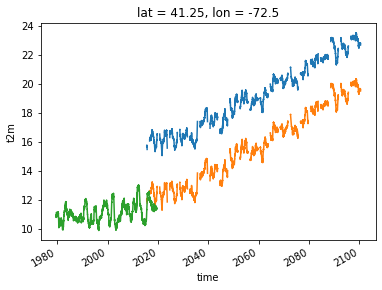

In [205]:
model = 30

us_east_c = USeast.future.sel(model='CanESM5')
us_east_c.isel(member=model).tas.rolling(
            time=365, center=True).mean().plot()
result.isel(member=model).rolling(
            time=365, center=True).mean().plot()
reanalysis_daily.t2m.rolling(
            time=365, center=True).mean().plot()

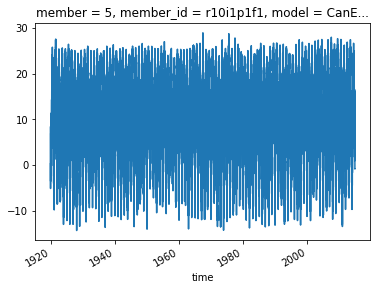

In [191]:
result.isel(member=model).plot()


In [14]:
regions = {
    'USeast' :{  'lat':41.3, 'lon':-72.5},
    'USwest' :  {'lat':37.7, 'lon':-122.4,},
    'iceland' :  {'lat':65, 'lon':-19},
    'europe' :  {'lat':51,'lon':10.5},
    'australia' : {'lat':-25.2,'lon':133.7},
    'tropics' : {'lat':3.9,'lon':-53.1}
    }

In [16]:
regions.keys()

dict_keys(['USeast', 'USwest', 'iceland', 'europe', 'australia', 'tropics'])

In [17]:
regions = {
    'USeast': {'lat': 41.3, 'lon': -72.5},
    'USwest':  {'lat': 37.7, 'lon': -122.4, },
    'iceland':  {'lat': 65, 'lon': -19},
    'europe':  {'lat': 51, 'lon': 10.5},
    'australia': {'lat': -25.2, 'lon': 133.7},
    'tropics': {'lat': 3.9, 'lon': -53.1}
}


for region in ['iceland', 'europe', 'australia', 'tropics']:

    lat = regions[region]['lat']
    lon = regions[region]['lon']

    print(lat)
    print(lon)

65
-19
51
10.5
-25.2
133.7
3.9
-53.1
